<a href="https://colab.research.google.com/github/modouktouray/farm_instrusion_detection/blob/main/farm_intrusion_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# Unzip folders
from google.colab import files

import zipfile
import os

# Unzip the training data
train_zip_path = "train.zip"
test_zip_path = "test.zip"

# Extract training data
with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/train')

# Extract testing data
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/test')

# Verify Folder Structure
print("Training data contents:")
print(os.listdir('/content/train'))

print("\nTesting data contents:")
print(os.listdir('/content/test'))

Training data contents:
['train']

Testing data contents:
['test']


In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import random

# Function to apply a night-time effect to an images
def apply_night_effect(image):
    """
    Simulates a night-time effect by reducing brightness and adding a bluish tint.
    """
    # Reduce brightness
    alpha = 0.6
    beta = -50
    darkened = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)

    # Add a bluish tint
    blue_tint = np.zeros_like(darkened)
    blue_tint[:, :, 0] = 50
    night_effect = cv2.addWeighted(darkened, 0.8, blue_tint, 0.2, 0)

    return night_effect

# Paths for input and output directories
train_dir = '/content/train/train'
output_dir = '/content/train_augmented'
os.makedirs(output_dir, exist_ok=True)

# Augment images for each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name}")
    output_class_path = os.path.join(output_dir, class_name)
    os.makedirs(output_class_path, exist_ok=True)

    # List all images in the current class folder
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    num_night_effects = len(image_files) // 2  # Augment 50% of the images

    # Randomly select images for augmentation
    random.shuffle(image_files)
    selected_images = image_files[:num_night_effects]

    # Apply night-time effect
    for img_file in tqdm(selected_images, desc=f"Augmenting {class_name}"):
        img_path = os.path.join(class_path, img_file)
        image = cv2.imread(img_path)

        night_image = apply_night_effect(image)

        # Save the augmented image
        output_path = os.path.join(output_class_path, img_file)
        cv2.imwrite(output_path, night_image)

    # Copy remaining images to the augmented folder
    for img_file in image_files[num_night_effects:]:
        img_path = os.path.join(class_path, img_file)
        output_path = os.path.join(output_class_path, img_file)
        image = cv2.imread(img_path)
        cv2.imwrite(output_path, image)

print("Night-time augmentation complete. Augmented dataset is ready.")


Processing class: humans


Augmenting humans: 100%|██████████| 450/450 [00:00<00:00, 784.47it/s]


Processing class: monkeys


Augmenting monkeys: 100%|██████████| 524/524 [00:09<00:00, 53.90it/s]


Night-time augmentation complete. Augmented dataset is ready.


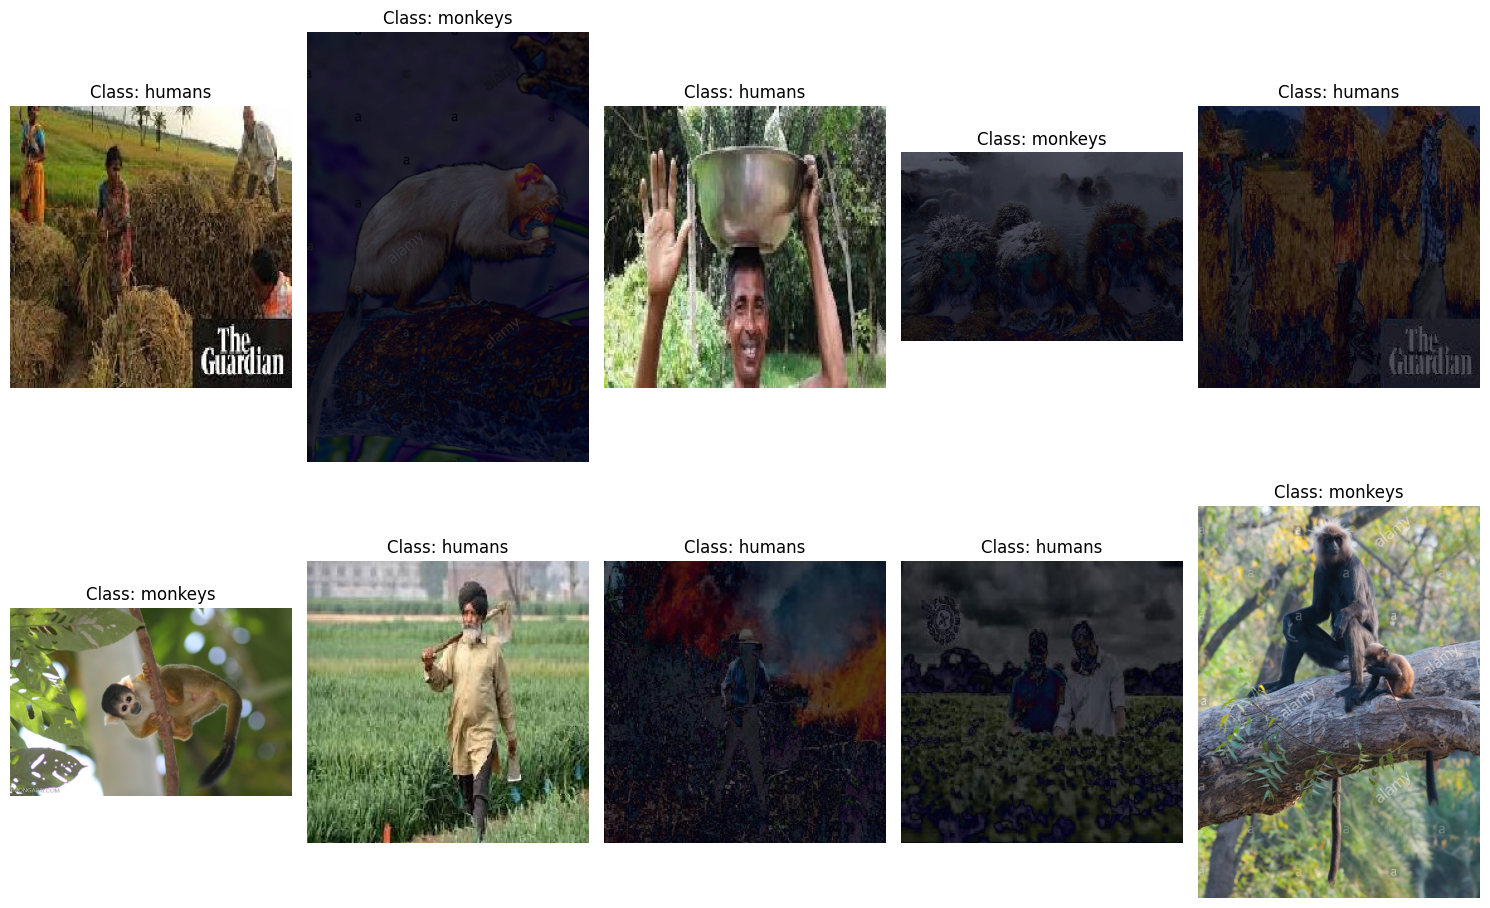

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

# Path to the augmented dataset
augmented_dir = '/content/train_augmented'

# Function to load and display images
def display_augmented_images(augmented_dir, num_images=10):
    """
    Display a specified number of randomly selected augmented images from the dataset.
    """
    all_images = []

    # Traverse the augmented dataset and collect file paths
    for class_name in os.listdir(augmented_dir):
        class_path = os.path.join(augmented_dir, class_name)
        if os.path.isdir(class_path):
            images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
            all_images.extend(images)

    # Randomly select images to display
    selected_images = random.sample(all_images, min(num_images, len(all_images)))

    # Display images
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        plt.subplot(2, 5, i + 1)  # Create a grid for 10 images
        plt.imshow(img)
        plt.title(f"Class: {os.path.basename(os.path.dirname(img_path))}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to display augmented images
display_augmented_images(augmented_dir, num_images=10)


In [ ]:
# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
INITIAL_LR = 1e-4
FINE_TUNE_LR = 1e-5  # Lower learning rate for fine-tuning

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Data
train_generator = train_datagen.flow_from_directory(
    '/content/train_augmented',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/test/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 1949 images belonging to 2 classes.
Found 398 images belonging to 2 classes.


In [ ]:
# Load Base Model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze the base model initially

# Add Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the Model
model.compile(optimizer=AdamW(learning_rate=INITIAL_LR, weight_decay=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model Summary
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train Top Layers Only
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS // 2,  # Train for half of the epochs with frozen base layers
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


61/61 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.4930 - loss: 0.6971 - val_accuracy: 0.4975 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 2/7
61/61 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.5513 - loss: 0.6894 - val_accuracy: 0.4975 - val_loss: 0.6963 - learning_rate: 1.0000e-04
Epoch 3/7
61/61 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5040 - loss: 0.6935 - val_accuracy: 0.4975 - val_loss: 0.6968 - learning_rate: 1.0000e-04
Epoch 4/7
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5240 - loss: 0.6936
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
61/61 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.5242 - loss: 0.6935 - val_accuracy: 0.4975 - val_loss: 0.6992 - learning_rate: 1.0000e-04
Epoch 5/7
61/61 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.5427 - loss: 0.6879 - val_accuracy: 0.4975 - val_loss: 0.6983 - learning_rate: 5.0000e-05
Epoch 6/7
61/61 ━━━━━━━━━━━━━━━━━━━━ 226s 4s/step - accuracy: 0.5431 - loss: 0.6914 - val_ac

In [ ]:

# Step 5: Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.2080 - loss: 0.7378

Test Accuracy: 49.75%
Test Loss: 0.6961


In [ ]:
# Fine-Tune Base Model
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Freeze all but the last 20 layers
    layer.trainable = False

# Compile with a Lower Learning Rate for Fine-Tuning
model.compile(optimizer=AdamW(learning_rate=FINE_TUNE_LR, weight_decay=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-Tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 231s 3s/step - accuracy: 0.4572 - loss: 0.7709 - val_accuracy: 0.4975 - val_loss: 0.6989 - learning_rate: 1.0000e-05
Epoch 2/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 230s 4s/step - accuracy: 0.4818 - loss: 0.7284 - val_accuracy: 0.4975 - val_loss: 0.7120 - learning_rate: 1.0000e-05
Epoch 3/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 221s 4s/step - accuracy: 0.5209 - loss: 0.7116 - val_accuracy: 0.4975 - val_loss: 0.7138 - learning_rate: 1.0000e-05
Epoch 4/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5108 - loss: 0.7165
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
61/61 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.5108 - loss: 0.7165 - val_accuracy: 0.4975 - val_loss: 0.7082 - learning_rate: 1.0000e-05
Epoch 5/15
61/61 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.5065 - loss: 0.7068 - val_accuracy: 0.4975 - val_loss: 0.7063 - learning_rate: 5.0000e-06


13/13 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step

Classification Report:
              precision    recall  f1-score   support

      humans       0.00      0.00      0.00       200
     monkeys       0.50      1.00      0.66       198

    accuracy                           0.50       398
   macro avg       0.25      0.50      0.33       398
weighted avg       0.25      0.50      0.33       398



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


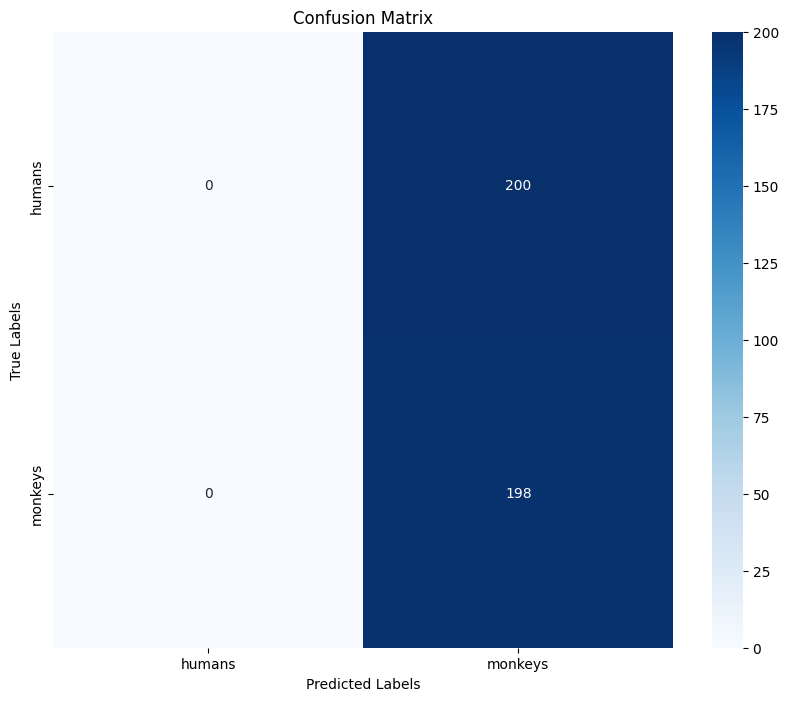

In [ ]:
# Step 6: Generate Predictions
predictions = model.predict(test_generator, verbose=1)
predicted_classes = (predictions > 0.5).astype(int)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Step 7: Classification Report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Step 8: Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

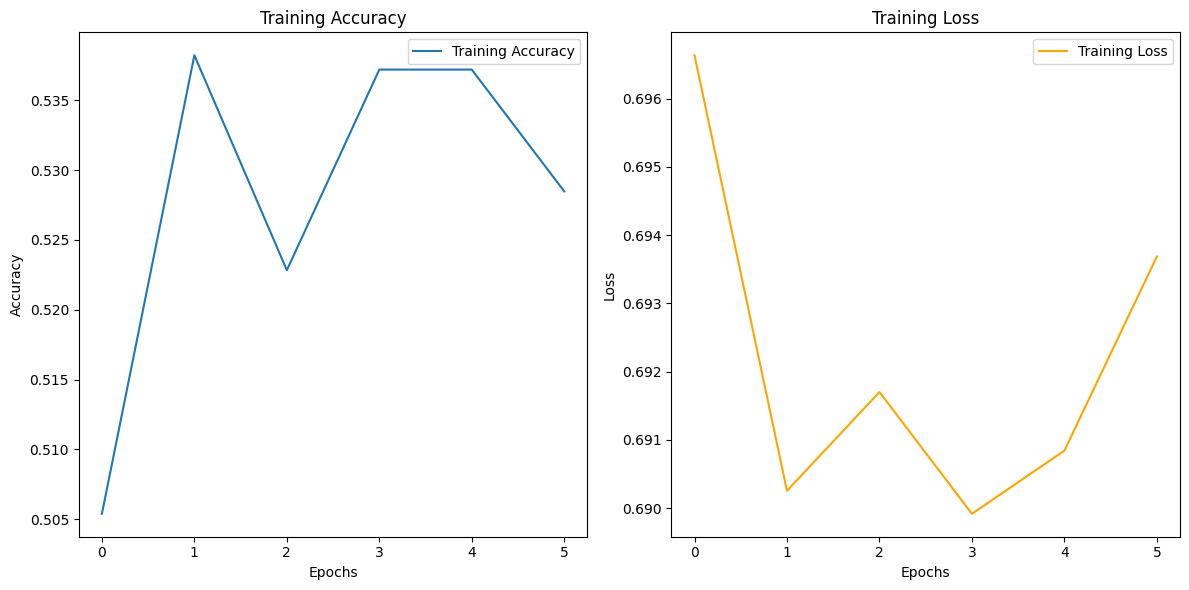

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    """
    Plot training and validation accuracy and loss curves.

    Args:
        history: Training history object from model.fit().
    """
    # Accuracy plot
    plt.figure(figsize=(12, 6))

    # Plot training accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history)


In [ ]:

# Step 8: Save the Model
model.save('/content/efficientnet_model.h5')
print("Model saved as efficientnet_model.h5")


Model saved as efficientnet_model.h5
